<a href="https://colab.research.google.com/github/ChristianParsons98/PG_Lab_Code/blob/main/LLYTO_A_Raman_FullFit_V4_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import pandas as pd
import math
import scipy
from scipy.stats import chisquare
print(scipy.__version__)
from scipy.optimize import leastsq
from scipy.special import voigt_profile
from sklearn.metrics import r2_score
import csv
from scipy.signal import find_peaks
import lmfit
from lmfit.models import VoigtModel, LinearModel, GaussianModel, LorentzianModel

#This document is used to fit the raman data to Lorentzians
#For LLYTO made with Anatase

#Uses file /content/LLYTO-2.PRN


1.16.1


In [3]:
#Importing the Results for LLTO and LLYTO

def Load_Raman_Data(file_path):
    #Function to load tab-delimited .PRN Raman data from Renishaw
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['wavenumber', 'intensity'])
    return df


#Load the file file
dfA2 = Load_Raman_Data('/content/LLYTO-2.PRN')

wna2 = dfA2['wavenumber'].to_numpy()
wna2 = wna2[:-1].astype(float)
intensitya2 = dfA2['intensity'].to_numpy()[:-1]

In [4]:
#Helper function to find peak indicies.
peaks, _ = find_peaks(intensitya2, prominence=1000)
#peaks = find_peaks(intensitya2, prominence=1000)
for peak in peaks:
  print(wna2[peak])

142.98
241.44
315.81
462.45
528.43
829.04


In [5]:
#If the peak is not showing up above this may help.

#helper function to find index closest to my guess angle
def closest(lst, K):
    val=lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(val)

#helper function to find index of nearest peak given a guess index
def peakfind(lst,K):
    temp=lst[K-15:K+15]
    maxval=max(temp)
    mindx=temp.index(maxval)
    #index = lst.index(maxval)
    index=K-15+mindx
    return index

In [6]:
#Example of using the above helper functions to find the index for a specific wavenumber
templst=wna2.tolist()
print(closest(templst,100))

48


In [7]:
#This function fits a voigt function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def VPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = VoigtModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    result.plot()
    print(result.fit_report())

In [8]:
#This function fits a Lorentzian function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def LPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    #params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    #result.plot()
    #print(result.fit_report())
    return result

In [9]:
#Same as above but for jointly fitting the two peaks that should be around 500
# One at ~525 and the other at ~580
# icenters is a list of two peak center indicies - lower index first.
def L2PeakFit(WN,Int,icenters,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki1= icenters[0]
    pkang1= WN[pki1]
    pki2= icenters[1]
    pkang2= WN[pki2]
    tempx=WN[pki1-nleft:pki2+nright]
    tempy=Int[pki1-nleft:pki2+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    model += LorentzianModel(prefix='p1_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang1, min=pkang1-10, max=pkang1+10)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)
    params.add(f'p1_center', value=pkang2, min=pkang2-20, max=pkang2+20)
    params.add(f'p1_sigma', value=20, min=0.01)
    params.add(f'p1_amplitude', value=1000000, min=0)


    result = model.fit(tempy, params, x=tempx)
    return result

In [10]:
#Now we go through and fit each peak individually...

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 20
    # variables        = 3
    chi-square         = 1.2876e+08
    reduced chi-square = 7573945.10
    Akaike info crit   = 319.554114
    Bayesian info crit = 322.541311
    R-squared          = 0.99490040
[[Variables]]
    p0_center:     143.654486 +/- 0.05711124 (0.04%) (init = 142.98)
    p0_sigma:      17.2029688 +/- 0.18623912 (1.08%) (init = 20)
    p0_amplitude:  21591773.1 +/- 197780.670 (0.92%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9821
    C(p0_center, p0_amplitude) = +0.2919
    C(p0_center, p0_sigma)     = +0.2746


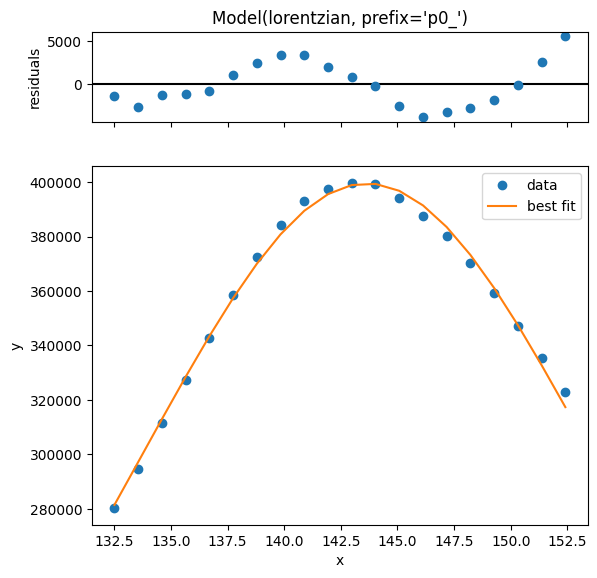

In [11]:
Peak1 = LPeakFit(wna2, intensitya2,peaks[0],10,10)
Peak1.plot()
print(Peak1.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 20
    # variables        = 3
    chi-square         = 2126698.82
    reduced chi-square = 125099.930
    Akaike info crit   = 237.486984
    Bayesian info crit = 240.474181
    R-squared          = 0.98499886
[[Variables]]
    p0_center:     240.837845 +/- 0.08203853 (0.03%) (init = 241.44)
    p0_sigma:      46.1053259 +/- 0.70878036 (1.54%) (init = 20)
    p0_amplitude:  26097951.8 +/- 388367.400 (1.49%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude) = +0.9996


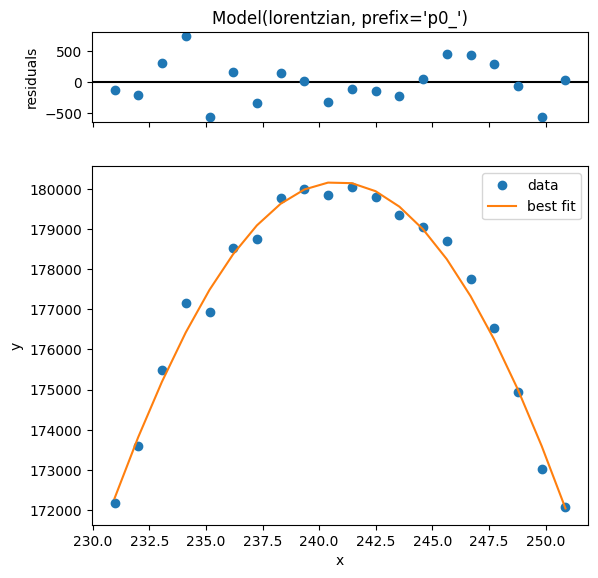

In [12]:
Peak2 = LPeakFit(wna2, intensitya2,peaks[1],10,10)
Peak2.plot()
print(Peak2.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 20
    # variables        = 3
    chi-square         = 5164481.88
    reduced chi-square = 303793.052
    Akaike info crit   = 255.231661
    Bayesian info crit = 258.218858
    R-squared          = 0.95545727
[[Variables]]
    p0_center:     318.177082 +/- 0.29512557 (0.09%) (init = 315.81)
    p0_sigma:      50.4386355 +/- 1.94363439 (3.85%) (init = 20)
    p0_amplitude:  21076535.7 +/- 794995.190 (3.77%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9996
    C(p0_center, p0_amplitude) = +0.7183
    C(p0_center, p0_sigma)     = +0.7106


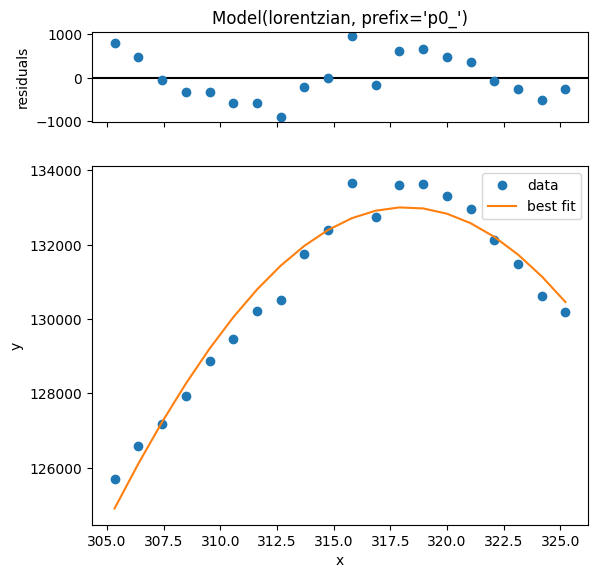

In [13]:
Peak3 = LPeakFit(wna2, intensitya2,peaks[2],10,10)
Peak3.plot()
print(Peak3.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 20
    # variables        = 3
    chi-square         = 1254866.76
    reduced chi-square = 73815.6918
    Akaike info crit   = 226.936154
    Bayesian info crit = 229.923351
    R-squared          = 0.97824140
[[Variables]]
    p0_center:     464.074876 +/- 0.15648812 (0.03%) (init = 462.45)
    p0_sigma:      43.9838980 +/- 1.03209159 (2.35%) (init = 20)
    p0_amplitude:  11507840.2 +/- 261721.466 (2.27%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9994
    C(p0_center, p0_amplitude) = +0.6032
    C(p0_center, p0_sigma)     = +0.5948


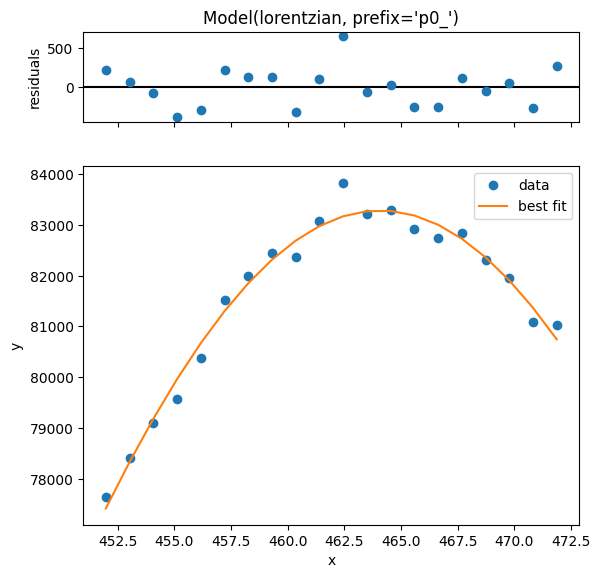

In [14]:
Peak4 = LPeakFit(wna2, intensitya2,peaks[3],10,10)
Peak4.plot()
print(Peak4.fit_report())

[[Model]]
    (Model(lorentzian, prefix='p0_') + Model(lorentzian, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 81
    # variables        = 6
    chi-square         = 9200632.64
    reduced chi-square = 122675.102
    Akaike info crit   = 954.867026
    Bayesian info crit = 969.233721
    R-squared          = 0.99974241
[[Variables]]
    p0_center:     524.866451 +/- 0.07388630 (0.01%) (init = 526.34)
    p0_sigma:      32.0980262 +/- 0.47718599 (1.49%) (init = 20)
    p0_amplitude:  10916785.9 +/- 427049.501 (3.91%) (init = 1000000)
    p1_center:     580.347221 +/- 0.99793790 (0.17%) (init = 579.76)
    p1_sigma:      64.3395483 +/- 2.96811997 (4.61%) (init = 20)
    p1_amplitude:  13233969.5 +/- 853712.230 (6.45%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_sigma, p1_amplitude)     = +0.9955
    C(p0_amplitude, p1_amplitude) = -0.9864
    C(p0_sigma, p0_amplitude)     = +0

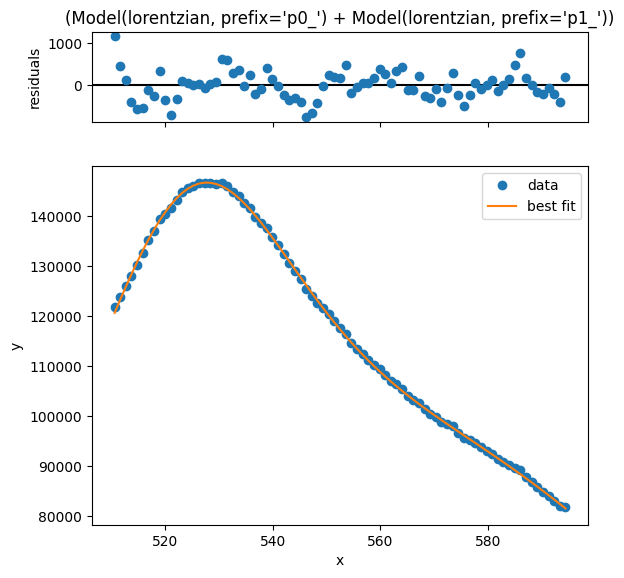

In [15]:
#The peaks at 525 and 580 near the indices 455 and 506.
Peaks5_6 = L2PeakFit(wna2, intensitya2,[455,506],15,15)
Peaks5_6.plot()
print(Peaks5_6.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 80
    # variables        = 3
    chi-square         = 16918224.9
    reduced chi-square = 219717.206
    Akaike info crit   = 986.950029
    Bayesian info crit = 994.096109
    R-squared          = 0.90389575
[[Variables]]
    p0_center:     822.736863 +/- 0.51701308 (0.06%) (init = 829.04)
    p0_sigma:      188.852364 +/- 4.06406874 (2.15%) (init = 20)
    p0_amplitude:  52674626.8 +/- 1100633.38 (2.09%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9996
    C(p0_center, p0_amplitude) = -0.4527
    C(p0_center, p0_sigma)     = -0.4472


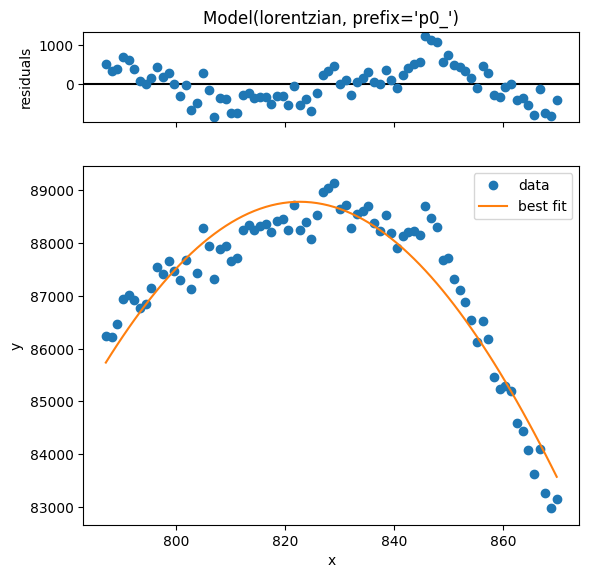

In [16]:
Peak7 = LPeakFit(wna2, intensitya2,peaks[5],40,40)
Peak7.plot()
print(Peak7.fit_report())

In [17]:
def lorentzian(x, x0, sigma, amplitude):
        return amplitude/np.pi * (sigma / ((x - x0)**2 + sigma**2))

In [18]:
#But the amplitude is not exactly correct when we jointly fit. Peak center should be ok.

In [19]:
#Let's make a list of values
pvlst=[]

#peaks 1-4
PL = [Peak1, Peak2, Peak3, Peak4]
for peak in PL:
    tdl = list(peak.params.valuesdict().values())
    pvlst.append(tdl)
#peaks 5-6
pvlst.append(list(Peaks5_6.params.valuesdict().values())[:3])
pvlst.append(list(Peaks5_6.params.valuesdict().values())[3:])
#peak 7
pvlst.append(list(Peak7.params.valuesdict().values()))

print(pvlst)

[[143.65448562892604, 17.20296876619447, 21591773.13958724], [240.83784549287438, 46.10532591156409, 26097951.82369181], [318.17708207489244, 50.43863545957811, 21076535.70543759], [464.0748764589061, 43.9838979834664, 11507840.159224447], [524.8664514970208, 32.09802615608159, 10916785.89061525], [580.3472205520698, 64.33954834477242, 13233969.481326947], [822.7368627866658, 188.85236440086354, 52674626.795325115]]


[[Model]]
    ((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2989
    # data points      = 833
    # variables        = 14
    chi-square         = 1.0010e+11
    reduced chi-square = 1.2223e+08
    Akaike info crit   = 15525.4958
    Bayesian info crit = 15591.6463
    R-squared          = 0.96013732
##  Warning: uncertainties could not be estimated:
    p1_sigma:      at boundary
    p4_sigma:      at boundary
    p4_amplitude:  at boundary
    p5_sigma:      at boundary
    p6_amplitude:  at boundary
[[Variables]]
    p1_center:     143.6545 (fixed)
    p1_sigma:      20.6435619 (init = 17.20297)
    p1_amplitude:  22199533.4 (init = 2.159177e+07)
    p2_center:     240.8378 (fixed)
    p2_sigma:      47.27612

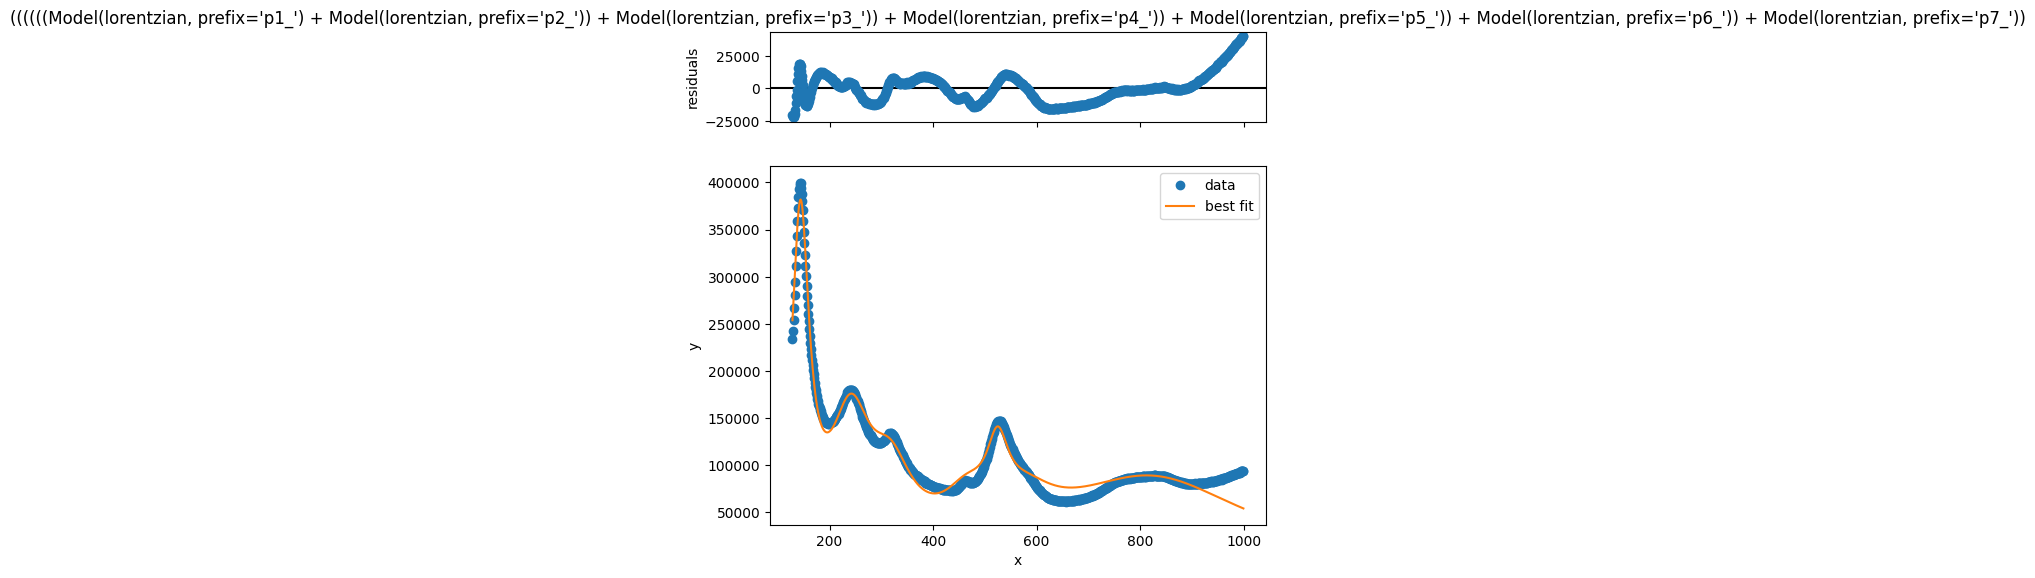

In [20]:
#We will see that we cannot fully fit the spectrum with the expected 7 peaks.
#There is a small piece missing around 390 cm-1...
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 8):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.8, max=pvlst[i-1][1]*1.2)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.5, max=pvlst[i-1][2]*1.5)

result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

[[Model]]
    (((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 857
    # data points      = 833
    # variables        = 17
    chi-square         = 5.9139e+10
    reduced chi-square = 72474634.3
    Akaike info crit   = 15093.0805
    Bayesian info crit = 15173.4061
    R-squared          = 0.97644986
##  Warning: uncertainties could not be estimated:
    p3_sigma:      at boundary
    p4_amplitude:  at boundary
    p6_sigma:      at boundary
    p6_amplitude:  at boundary
    p7_sigma:      at boundary
[[Variables]]
    p1_center:     143.6545 (fixed)
    p1_sigma:      19.6346082 (init = 17.20297)
    p1_amplitude:  20991266.8 (init = 2.159177e+07)
    p2_center:     240.8378 

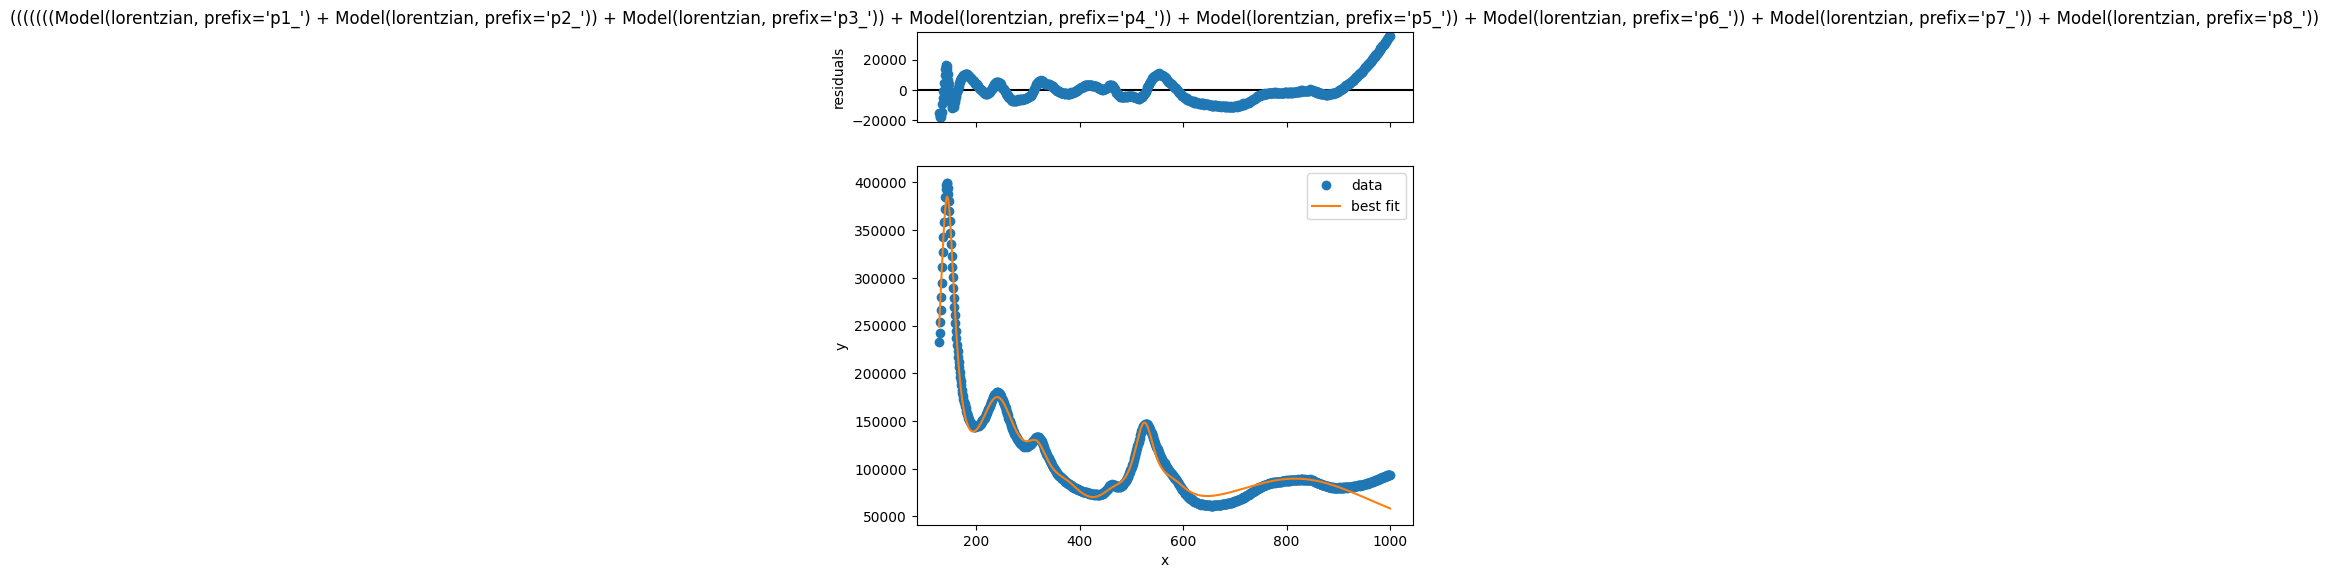

In [26]:
#As above but adding an additional peak around 390
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 9):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.6, max=pvlst[i-1][1]*1.3)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.2, max=pvlst[i-1][2]*1.9)

#There seems to be something going on around ~390 that needs to be accounted for...
params.add(f'p8_center', value=390, min=360, max=420)
params.add(f'p8_sigma', value=20, min=0.01)
params.add(f'p8_amplitude', value=1000000, min=0)


result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

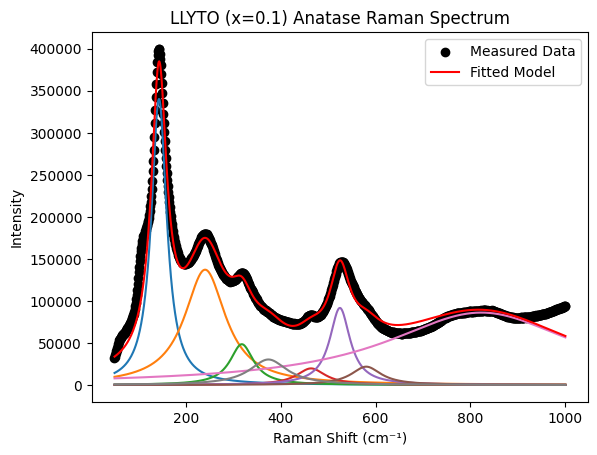

In [28]:
#Make a nice plot

ysim=np.zeros(1000)
xsim=np.linspace(50,1000,1000)

rdict = result.params.valuesdict()

plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("LLYTO (x=0.1) Anatase Raman Spectrum")
plt.scatter(wna2,intensitya2, c='k', label='Measured Data')
for i in range(1,9):
  y= lorentzian(xsim, rdict[f'p{i}_center'], rdict[f'p{i}_sigma'], rdict[f'p{i}_amplitude'])
  ysim+=y
  plt.plot(xsim,y)
plt.plot(xsim,ysim,'r', label='Fitted Model')
plt.legend()
plt.savefig('LLYTO_Anatase_Raman_FullFit.png',dpi=600)
plt.show()

In [29]:
print('LLYTO_Anatase_Params')
result.params.valuesdict()

LLYTO_Anatase_Params


{'p1_center': 143.65448562892604,
 'p1_sigma': 19.63460824866243,
 'p1_amplitude': 20991266.79683625,
 'p2_center': 240.83784549287438,
 'p2_sigma': 52.7389214213629,
 'p2_amplitude': 22727185.15665669,
 'p3_center': 318.17708207489244,
 'p3_sigma': 30.26318127629135,
 'p3_amplitude': 4613919.869939277,
 'p4_center': 464.0748764589061,
 'p4_sigma': 37.10830809370353,
 'p4_amplitude': 2301568.0321470858,
 'p5_center': 524.8664514970208,
 'p5_sigma': 26.044329270365253,
 'p5_amplitude': 7500710.744759677,
 'p6_center': 580.3472205520698,
 'p6_sigma': 38.60372906576389,
 'p6_amplitude': 2646793.896612336,
 'p7_center': 822.7368627866658,
 'p7_sigma': 245.508073719084,
 'p7_amplitude': 66448775.448407404,
 'p8_center': 374.21655398238136,
 'p8_sigma': 48.187131913509354,
 'p8_amplitude': 4596149.924140921}